# Hello, everyone My name is Mostafa Emad AL-din Essam, and I'm excited to guide you through an My Project
# Stock Price Prediction and Sentiment Analysis Project

## Overview

This project aims to predict stock prices by combining numerical analysis of historical stock data with sentiment analysis of news headlines. The hybrid model integrates quantitative features from stock data and sentiment scores obtained from textual data to create a more comprehensive approach for predicting stock prices.

In [1]:
# Data processing
import pandas as pd
import math
import numpy as np
import librosa
import os
import yfinance as yf
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Model and performance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer

### 1. Data Collection

- **Stock Data:** Download historical stock data from Yahoo Finance using the `yfinance` library.
- **News Headlines:** Collect news headlines related to the stock from a suitable source.
- **Date Selection:** I selected Date Between 2001-01-01 and 2021-12-31


In [2]:
import yfinance as yf
sensex_data = yf.download('^BSESN', start='2001-01-01', end='2021-12-31')
df=pd.read_csv("india-news-headlines.csv")

[*********************100%%**********************]  1 of 1 completed


In [3]:
df.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 83.6+ MB


In [5]:
df.describe()

,publish_date
count,3.650970e+06
mean,2.013193e+07
std,5.252282e+04
min,2.001010e+07
25%,2.010042e+07
50%,2.014023e+07
75%,2.017093e+07
max,2.022033e+07


In [6]:
df['publish_date'] = pd.to_datetime(df['publish_date'], format='%Y%m%d')
df['headline_text'] = df['headline_text'].str.lower()  # Convert to lowercase
df['headline_text'] = df['headline_text'].str.replace('[^a-zA-Z\s]', '')  # Remove non-alphabetic characters

In [7]:
df.head()

,publish_date,headline_category,headline_text
0,2001-01-02,unknown,status quo will not be disturbed at ayodhya; s...
1,2001-01-02,unknown,fissures in hurriyat over pak visit
2,2001-01-02,unknown,america's unwanted heading for india?
3,2001-01-02,unknown,for bigwigs; it is destination goa
4,2001-01-02,unknown,extra buses to clear tourist traffic


In [8]:
filtered_df = df[(df['publish_date'] >= '2000-01-01') & (df['publish_date'] <= '2021-12-31')]
filtered_df = filtered_df.reset_index(drop=True)
filtered_df.head()

,publish_date,headline_category,headline_text
0,2001-01-02,unknown,status quo will not be disturbed at ayodhya; s...
1,2001-01-02,unknown,fissures in hurriyat over pak visit
2,2001-01-02,unknown,america's unwanted heading for india?
3,2001-01-02,unknown,for bigwigs; it is destination goa
4,2001-01-02,unknown,extra buses to clear tourist traffic


### 2. Data Preprocessing

- **Stock Data:** Clean the stock data, handle missing values, and format the data into a DataFrame.
- **News Headlines:** Preprocess the headlines, including tokenization and sentiment analysis.

In [9]:
num_categories = filtered_df['headline_category'].nunique()
print(f'Number of Unique Headline Categories: {num_categories}')

Number of Unique Headline Categories: 1041


In [10]:
num_duplicates = filtered_df.duplicated().sum()
print(f'Number of duplicates in the DataFrame: {num_duplicates}')

Number of duplicates in the DataFrame: 25058


In [11]:
filtered_df.drop_duplicates(inplace=True)

In [12]:
num_duplicates = filtered_df.duplicated().sum()
print(f'Number of duplicates in the DataFrame: {num_duplicates}')

Number of duplicates in the DataFrame: 0


In [13]:
sensex_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0
2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0
2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0
2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0
2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0


In [14]:
sensex_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5173 entries, 2001-01-02 to 2021-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5173 non-null   float64
 1   High       5173 non-null   float64
 2   Low        5173 non-null   float64
 3   Close      5173 non-null   float64
 4   Adj Close  5173 non-null   float64
 5   Volume     5173 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 282.9 KB


In [15]:
sensex_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5173.000000,5173.000000,5173.000000,5173.000000,5173.000000,5.173000e+03
mean,20292.884295,20411.622603,20132.886298,20270.408089,20270.408089,7.696810e+04
std,13346.385890,13394.022756,13261.053632,13326.343740,13326.343740,1.040721e+06
min,2621.889893,2682.590088,2594.870117,2600.120117,2600.120117,0.000000e+00
25%,9271.629883,9379.679688,9125.650391,9283.160156,9283.160156,9.200000e+03
50%,18056.240234,18213.210938,17910.300781,18044.640625,18044.640625,1.380000e+04
75%,28270.109375,28393.419922,28097.119141,28227.390625,28227.390625,2.040000e+04
max,62156.480469,62245.429688,61624.648438,61765.589844,61765.589844,3.181510e+07


In [16]:
missing_data_count = sensex_data.isna().sum()
print("Number of Missing Values in Stock Data:")
print(missing_data_count)

Number of Missing Values in Stock Data:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


### 3. Feature Engineering

- **Stock Data:** Calculate technical indicators such as Simple Moving Average (SMA), Exponential Moving Average (EMA), and Relative Strength Index (RSI).
- **News Headlines:** 
  - Tokenization: Tokenize the headlines to break them into individual words.
  - Sentiment Analysis: Perform sentiment analysis on the headlines to quantify sentiment.
  - Preprocessing: Apply necessary preprocessing steps, such as removing stop words and special characters.
- **Combined Data:** Merge the stock data with the preprocessed news headlines and then saved it as a csv file to load it to the model


In [17]:
sensex_data['SMA_50'] = sensex_data['Close'].rolling(window=50).mean()

sensex_data['EMA_20'] = sensex_data['Close'].ewm(span=20, adjust=False).mean()

time_period = 14

delta = sensex_data['Close'].diff(1)

gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

average_gain = gain.rolling(window=time_period, min_periods=1).mean()
average_loss = loss.rolling(window=time_period, min_periods=1).mean()

rs = average_gain / average_loss

sensex_data['RSI'] = 100 - (100 / (1 + rs))

print(sensex_data[['Close', 'SMA_50', 'EMA_20', 'RSI']])

                   Close        SMA_50        EMA_20         RSI
Date                                                            
2001-01-02   4018.879883           NaN   4018.879883         NaN
2001-01-03   4060.020020           NaN   4022.797991  100.000000
2001-01-04   4115.370117           NaN   4031.614384  100.000000
2001-01-05   4183.729980           NaN   4046.101584  100.000000
2001-01-08   4120.430176           NaN   4053.180497   72.255169
...                  ...           ...           ...         ...
2021-12-24  57124.308594  59133.820703  57659.384438   52.711267
2021-12-27  57420.238281  59067.484453  57636.608614   48.323562
2021-12-28  57897.480469  58999.315078  57661.453552   43.544683
2021-12-29  57806.488281  58920.133047  57675.266383   41.313495
2021-12-30  57794.320312  58841.698438  57686.604853   41.373036

[5173 rows x 4 columns]


In [18]:
missing_data_count = sensex_data.isna().sum()
print("Number of Missing Values in Stock Data:")
print(missing_data_count)

Number of Missing Values in Stock Data:
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
SMA_50       49
EMA_20        0
RSI           1
dtype: int64


In [19]:
sensex_data['SMA_50'].fillna(sensex_data['SMA_50'].mean(), inplace=True)
sensex_data['RSI'].fillna(sensex_data['RSI'].mean(), inplace=True)

In [20]:
missing_data_count = sensex_data.isna().sum()
print("Number of Missing Values in Stock Data:")
print(missing_data_count)

Number of Missing Values in Stock Data:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
SMA_50       0
EMA_20       0
RSI          0
dtype: int64


In [21]:
sensex_data.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_50,EMA_20,RSI
Date,,,,,,,,,
2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0,20166.409543,4018.879883,55.225467
2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0,20166.409543,4022.797991,100.000000
2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0,20166.409543,4031.614384,100.000000
2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0,20166.409543,4046.101584,100.000000
2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0,20166.409543,4053.180497,72.255169


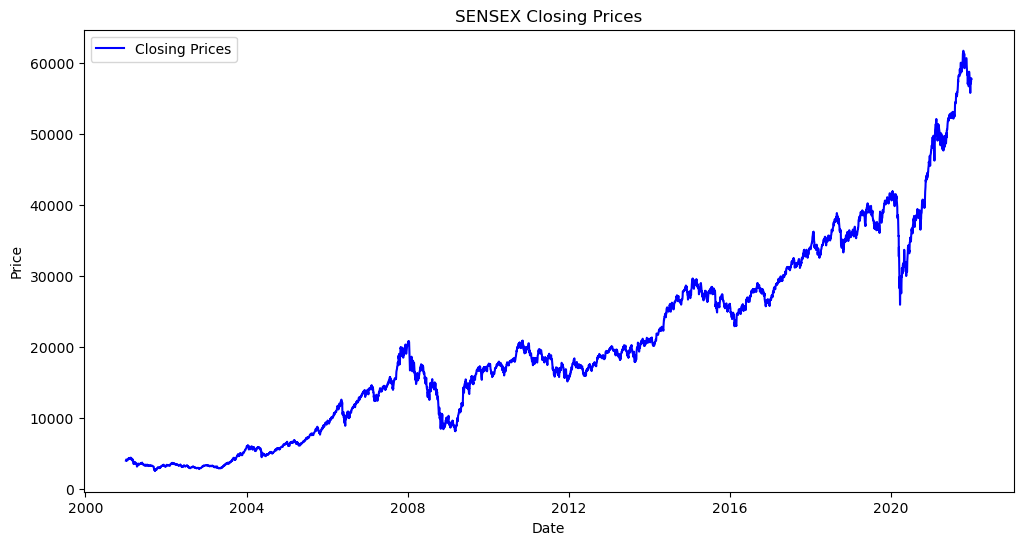

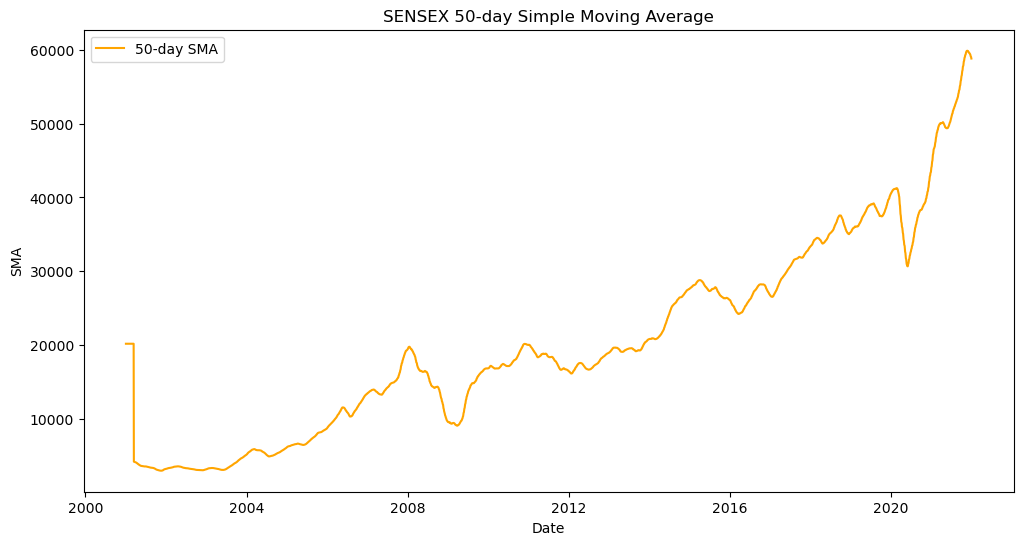

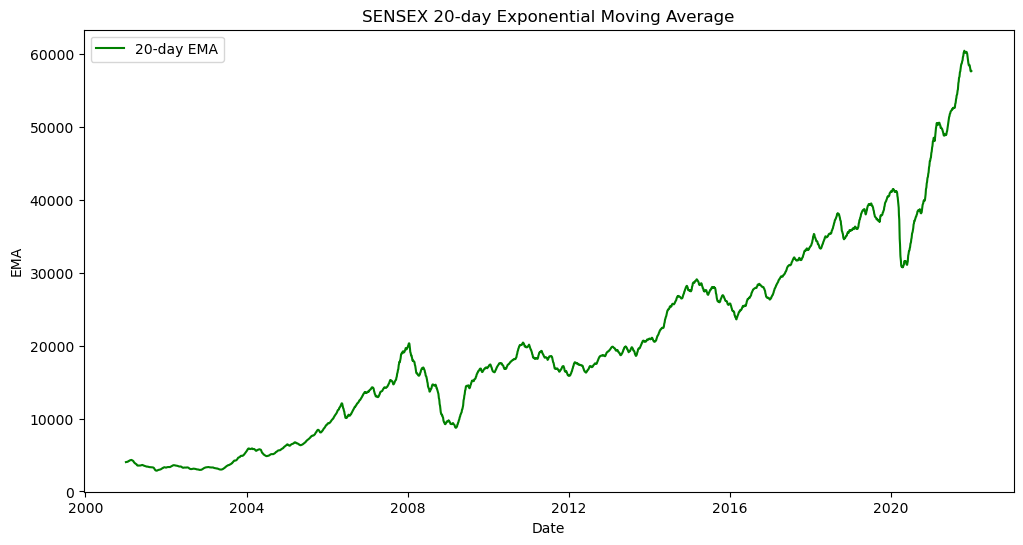

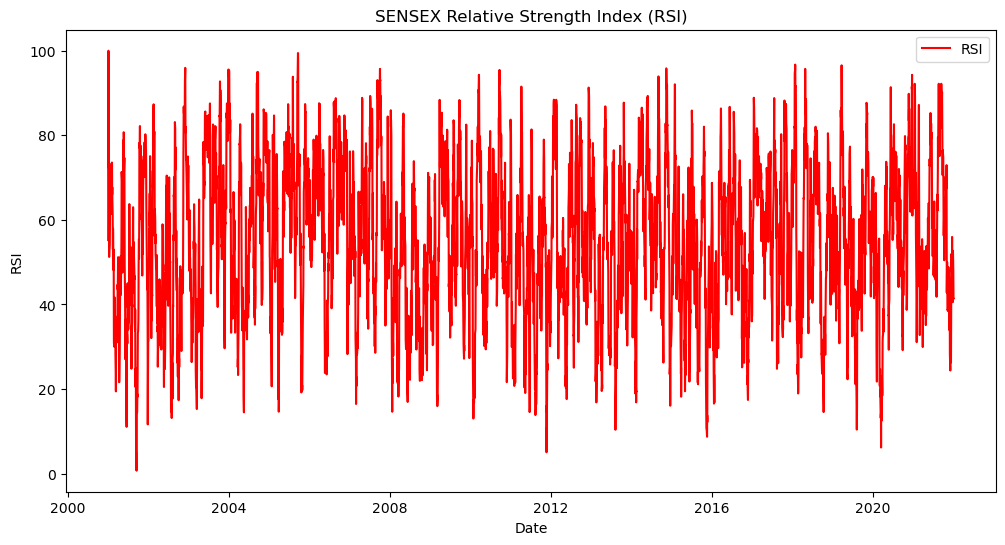

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(sensex_data['Close'], label='Closing Prices', color='blue')
plt.title('SENSEX Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot 50-day SMA
plt.figure(figsize=(12, 6))
plt.plot(sensex_data['SMA_50'], label='50-day SMA', color='orange')
plt.title('SENSEX 50-day Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('SMA')
plt.legend()
plt.show()

# Plot 20-day EMA
plt.figure(figsize=(12, 6))
plt.plot(sensex_data['EMA_20'], label='20-day EMA', color='green')
plt.title('SENSEX 20-day Exponential Moving Average')
plt.xlabel('Date')
plt.ylabel('EMA')
plt.legend()
plt.show()

# Plot RSI
plt.figure(figsize=(12, 6))
plt.plot(sensex_data['RSI'], label='RSI', color='red')
plt.title('SENSEX Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.show()

In [23]:
def preprocess_headlines(headlines):
    tokenized_headlines = [word_tokenize(headline) for headline in headlines]

    tokenized_headlines = [[word.lower() for word in tokens] for tokens in tokenized_headlines]

    tokenized_headlines = [[word for word in tokens if word.isalnum()] for tokens in tokenized_headlines]

    stop_words = set(stopwords.words('english'))
    tokenized_headlines = [[word for word in tokens if word not in stop_words] for tokens in tokenized_headlines]
    ps = PorterStemmer()
    tokenized_headlines = [[ps.stem(word) for word in tokens] for tokens in tokenized_headlines]

    return tokenized_headlines

filtered_df['tokenized_headlines'] = preprocess_headlines(filtered_df['headline_text'])

print(filtered_df[['publish_date', 'headline_category', 'headline_text', 'tokenized_headlines']])
def preprocess_headlines(headlines):
    sid = SentimentIntensityAnalyzer()
    filtered_df['compound'] = filtered_df['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    return filtered_df['compound']

filtered_df['compound'] = preprocess_headlines(filtered_df['headline_text'])

        publish_date                                headline_category   
0         2001-01-02                                          unknown  \
1         2001-01-02                                          unknown   
2         2001-01-02                                          unknown   
3         2001-01-02                                          unknown   
4         2001-01-02                                          unknown   
...              ...                                              ...   
3606065   2021-12-31                                   city.mangaluru   
3606066   2021-12-31                                   city.ghaziabad   
3606067   2021-12-31                                      city.indore   
3606068   2021-12-31                                  city.jamshedpur   
3606069   2021-12-31  elections.assembly-elections.uttar-pradesh.news   

                                             headline_text   
0        status quo will not be disturbed at ayodhya; s...  \

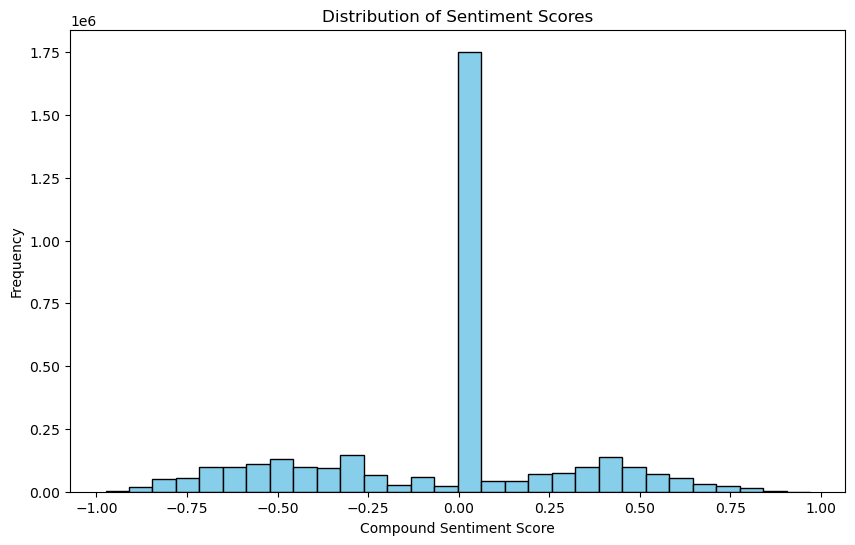

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['compound'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.show()

In [25]:
filtered_df['publish_date'] = pd.to_datetime(filtered_df['publish_date'], format='%Y%m%d')
merged_data = pd.merge(sensex_data, filtered_df, left_index=True, right_on='publish_date', how='inner')
merged_data = merged_data.drop(columns=['publish_date'])
merged_data = merged_data.reset_index(drop=True)
merged_data.drop(merged_data[merged_data['compound'] == 0].index, inplace=True)
merged_data.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_50,EMA_20,RSI,headline_category,headline_text,tokenized_headlines,compound
0,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0,20166.409543,4018.879883,55.225467,unknown,status quo will not be disturbed at ayodhya; s...,"[statu, quo, disturb, ayodhya, say, vajpaye]",0.2924
2,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0,20166.409543,4018.879883,55.225467,unknown,america's unwanted heading for india?,"[america, unwant, head, india]",-0.2263
4,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0,20166.409543,4018.879883,55.225467,unknown,extra buses to clear tourist traffic,"[extra, buse, clear, tourist, traffic]",0.3818
8,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0,20166.409543,4018.879883,55.225467,unknown,move to stop freedom fighters' pension flayed,"[move, stop, freedom, fighter, pension, flay]",0.4215
10,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0,20166.409543,4018.879883,55.225467,unknown,parivar dismisses pm's warning,"[parivar, dismiss, pm, warn]",-0.3400


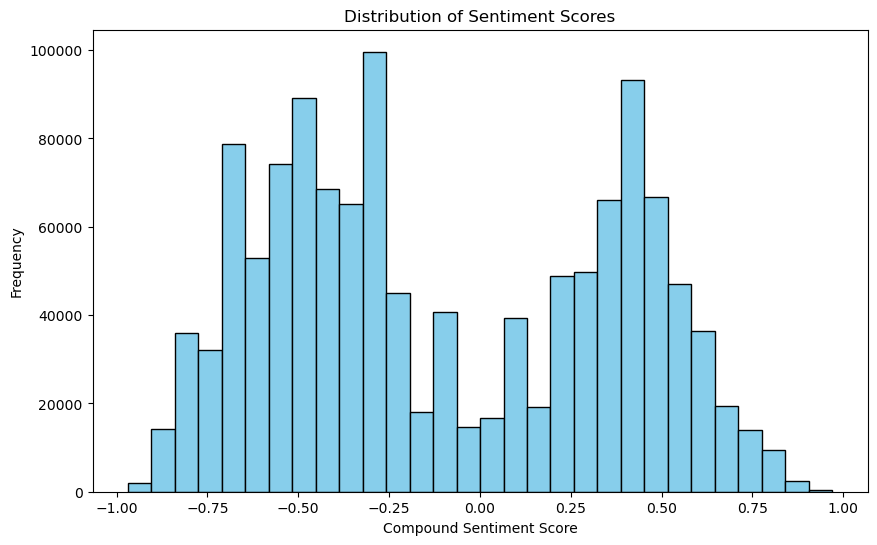

In [26]:
plt.figure(figsize=(10, 6))
plt.hist(merged_data['compound'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.show()

In [27]:
merged_data.to_csv('FinalData.csv', index=False)